# Notebook to make a cow' race classification for Angus, Hereford and no pure race

Comamand to execute a local instance of jupyter notebooks so it can be used with colab

In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 5.4 MB/s eta 0:00:00


Imports

In [ ]:
!pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyunpack import Archive
Archive('rawDataset.rar').extractall('')

In [ ]:
import tensorflow as tf  #version 2.10.0 
import keras
import numpy as np
from tensorflow.keras import layers
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import os

Constants

In [ ]:
height=224
width=224
img_dim_target=(height, width, 3)
root='/content/'  #change it to the directory you'll use to store images
post_dir=root+'rawDataset/'
batch_size=32
files_to_predict=root+'to_predict/'

Importing data to the model  (it is using 60% images for training, 20% for validating and 20% for testing )

In [ ]:
training_data=tf.keras.utils.image_dataset_from_directory(
    post_dir,
    shuffle=True,
    validation_split=0.4,
    image_size=(height, width),
    label_mode='categorical',
    class_names=['Angus','Hereford','NoRace'],
    subset='training',
    seed=123
)
validation_data=tf.keras.utils.image_dataset_from_directory(
    post_dir,
    shuffle=True,
    validation_split=0.4,
    image_size=(height, width),
    label_mode='categorical',
    class_names=['Angus','Hereford','NoRace'],
    subset='validation',
    seed=1234 
)

#test_data is to keep some untrained fresh data to test the model
validation_data, test_data = tf.keras.utils.split_dataset (validation_data, 0.5, 0.5, shuffle=True, seed=12345)

Found 512 files belonging to 3 classes.
Using 308 files for training.
Found 512 files belonging to 3 classes.
Using 204 files for validation.


Plot some training data 

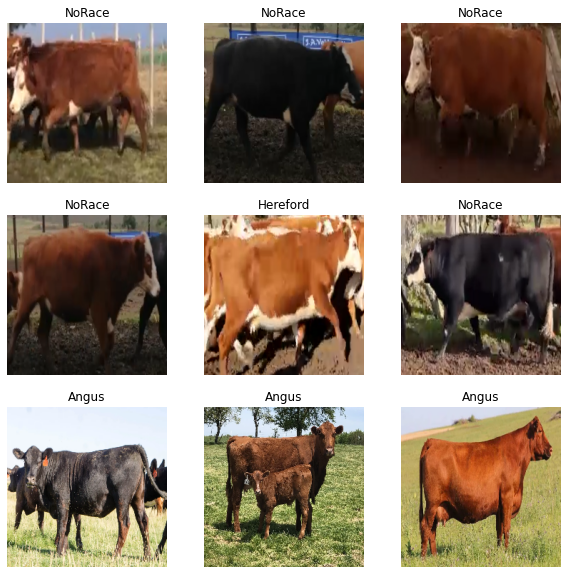

In [ ]:
classes = training_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[np.argmax(labels[i])])
    plt.axis("off")

Data augmenter function

In [ ]:
#it there is overfit try with different data augmentation
def data_augmenter():
  y=data_augmenter=tf.keras.Sequential()
  data_augmenter.add(layers.RandomFlip("horizontal"))
  data_augmenter.add(layers.RandomRotation((-0.06, 0.06)))
  return data_augmenter

Callback

In [ ]:
class Callback1(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy')> 0.99:
      print("\n Model has reached 99% accuracy")
      self.model.stop_training= True

Defining the Neural Network architecture with transfer learning (MobileNetV2)

In [ ]:
def first_model(image_shape=img_dim_target, data_augmentation=data_augmenter()):

  #setting the model which will be used to transfer its learning
  base_model=tf.keras.applications.MobileNetV2(input_shape=img_dim_target,
                                             include_top=False,
                                             weights='imagenet'
                                             )
  base_model.trainable= False

  inputs= tf.keras.Input(shape=image_shape)
  x=data_augmentation(inputs)
  x=tf.keras.applications.mobilenet_v2.preprocess_input(x)
  x=base_model(x, training=False)

  x = tf.keras.layers.GlobalAveragePooling2D()(x) 
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  return model

Instanciate model (do not worry about warnings)

In [ ]:
callback=Callback1()

model=first_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

history=model.fit(training_data, validation_data=validation_data,epochs=15, callbacks=[callback]) 

Epoch 1/15


10/10 [==============================] - 19s 299ms/step - loss: 1.0142 - accuracy: 0.4968 - val_loss: 0.8394 - val_accuracy: 0.5588
Epoch 2/15
10/10 [==============================] - 4s 132ms/step - loss: 0.5596 - accuracy: 0.7597 - val_loss: 0.5452 - val_accuracy: 0.8235
Epoch 3/15
10/10 [==============================] - 5s 204ms/step - loss: 0.3760 - accuracy: 0.8669 - val_loss: 0.4456 - val_accuracy: 0.8431
Epoch 4/15
10/10 [==============================] - 4s 132ms/step - loss: 0.3175 - accuracy: 0.8961 - val_loss: 0.3569 - val_accuracy: 0.8922
Epoch 5/15
10/10 [==============================] - 4s 131ms/step - loss: 0.2780 - accuracy: 0.8994 - val_loss: 0.3345 - val_accuracy: 0.8922
Epoch 6/15
10/10 [==============================] - 5s 225ms/step - loss: 0.2507 - accuracy: 0.9188 - val_loss: 0.2947 - val_accuracy: 0.9020
Epoch 7/15
10/10 [==============================] - 4s 133ms/step - loss: 0.2065 - accuracy: 0.9416 - val_loss: 0.2700 - val_accuracy: 0.9020
Epoch 8/15
10/10

Improve the model by training some previous layers

In [ ]:
for layer in model.layers[len(model.layers)-10:]:
  layer.trainable=True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine=model.fit(training_data,validation_data=validation_data,epochs=30, initial_epoch=history.epoch[-1], callbacks=[callback])

Epoch 15/30


10/10 [==============================] - 9s 206ms/step - loss: 0.1247 - accuracy: 0.9513 - val_loss: 0.1695 - val_accuracy: 0.9608
Epoch 16/30
10/10 [==============================] - 4s 133ms/step - loss: 0.1040 - accuracy: 0.9708 - val_loss: 0.1538 - val_accuracy: 0.9314
Epoch 17/30
10/10 [==============================] - 5s 147ms/step - loss: 0.0942 - accuracy: 0.9675 - val_loss: 0.1406 - val_accuracy: 0.9314
Epoch 18/30
10/10 [==============================] - 4s 134ms/step - loss: 0.1040 - accuracy: 0.9675 - val_loss: 0.1361 - val_accuracy: 0.9412
Epoch 19/30
10/10 [==============================] - 4s 128ms/step - loss: 0.0929 - accuracy: 0.9675 - val_loss: 0.1271 - val_accuracy: 0.9706
Epoch 20/30
10/10 [==============================] - 5s 174ms/step - loss: 0.0915 - accuracy: 0.9708 - val_loss: 0.1204 - val_accuracy: 0.9706
Epoch 21/30
10/10 [==============================] - 4s 133ms/step - loss: 0.0733 - accuracy: 0.9838 - val_loss: 0.1146 - val_accuracy: 0.9706
Epoch 22/30

In [ ]:
print(tf.__version__)

2.11.0


In [ ]:
import time

saved_model_path= "./{}.h5".format(int(time.time()))
model.save(saved_model_path)

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2023-03-21 15:48:34.576500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-21 15:48:34.576595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-21 15:48:34.576615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/  \
    /content/

2023-03-21 04:10:14.192752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-21 04:10:14.192848: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-21 04:10:14.192868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.9/dist-p

Test accuracy in the test set

In [ ]:
predictions=model.evaluate(test_data)

Test your own images

In [ ]:
to_predict=os.listdir(files_to_predict)
model= tf.keras.models.load_model(root+ 'models')
class_names=['Angus','Hereford','NoRace']

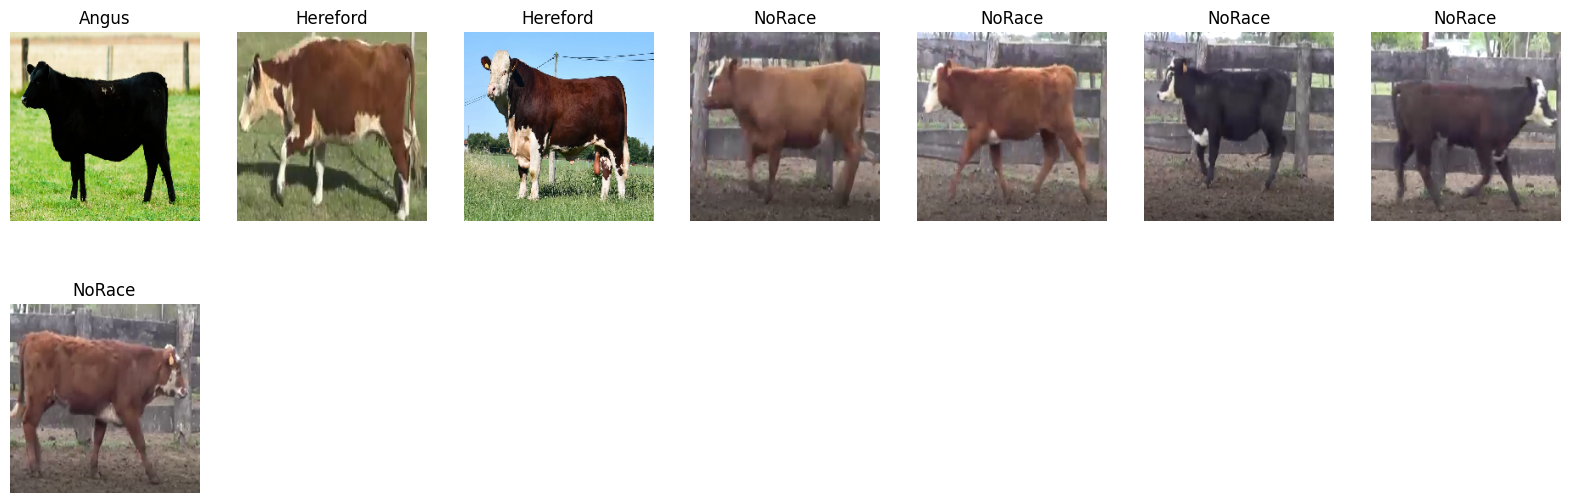

In [ ]:
counter=0
plt.figure(figsize=(20, 10))
rows=  np.ceil(len(to_predict)/7)

for fn in to_predict:
  path= files_to_predict +str(fn)

  image=  tf.keras.utils.load_img(path, target_size=(height,width))
  x =  tf.keras.utils.img_to_array(image)
  x = np.expand_dims(x, axis=0)
  x = np.vstack([x])
  classes = model.predict(x, batch_size=1, verbose=0)

  preds_classes = np.argmax(classes, axis=-1)
  
  ax = plt.subplot(3, 7, counter + 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(class_names[preds_classes[0]])

  counter+=1

Things to improve:

* Make a cell applying data augmentation in training to see it in action
* Make a cell to see the process of convolutions through examples